# Traffic flow prediction based on LSTM model

## Data Preprocessing

First import the data and add a new column "day of week" for training the holiday characteristic.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('LSTMdata/data.csv')

# Convert timestamp column to datetime type
data['Hour'] = pd.to_datetime(data['Hour'])

# add column "day of week"
data['day_of_week'] = data['Hour'].dt.dayofweek + 1

# View the basic information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Hour             744 non-null    datetime64[ns]
 1   Occupancy (%)    744 non-null    float64       
 2   Speed (mph)      744 non-null    float64       
 3   VMT (Veh-Miles)  744 non-null    float64       
 4   VHT (Veh-Hours)  744 non-null    float64       
 5   TTI              744 non-null    float64       
 6   South            744 non-null    float64       
 7   East             744 non-null    float64       
 8   North            744 non-null    float64       
 9   Flow (Veh/Hour)  744 non-null    float64       
 10  day_of_week      744 non-null    int64         
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 64.1 KB


Unified columns' type:

In [2]:
# Convert all columns except the TimeStamp to numeric
data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

data

,Hour,Occupancy (%),Speed (mph),VMT (Veh-Miles),VHT (Veh-Hours),TTI,South,East,North,Flow (Veh/Hour),day_of_week
0,2023-01-01 00:00:00,3.2,56.6,1599.1,28.2,1.1,1718.0,2289.0,1560.0,1929.0,7
1,2023-01-01 01:00:00,5.0,53.8,2583.2,48.0,1.1,2040.0,2989.0,2203.0,3116.0,7
2,2023-01-01 02:00:00,3.0,65.8,1864.4,28.3,0.9,1521.0,2580.0,1333.0,2249.0,7
3,2023-01-01 03:00:00,3.3,67.3,2175.3,32.3,0.9,904.0,2648.0,936.0,2624.0,7
4,2023-01-01 04:00:00,1.8,68.3,1131.6,16.6,0.9,774.0,1846.0,743.0,1365.0,7
...,...,...,...,...,...,...,...,...,...,...,...
739,2023-01-31 19:00:00,5.6,69.5,3049.9,43.9,0.9,4034.0,3229.0,4752.0,3679.0,2
740,2023-01-31 20:00:00,4.7,67.8,2449.7,36.1,0.9,3273.0,2936.0,3855.0,2955.0,2
741,2023-01-31 21:00:00,4.1,66.6,2012.8,30.2,0.9,2713.0,2875.0,3086.0,2428.0,2
742,2023-01-31 22:00:00,3.3,62.5,1454.1,23.3,1.0,2123.0,2804.0,2383.0,1754.0,2


In [3]:
# Set the timestamp column as an index
data.set_index('Hour', inplace=True)

View the relationship between the three related VDSs and the target VDS

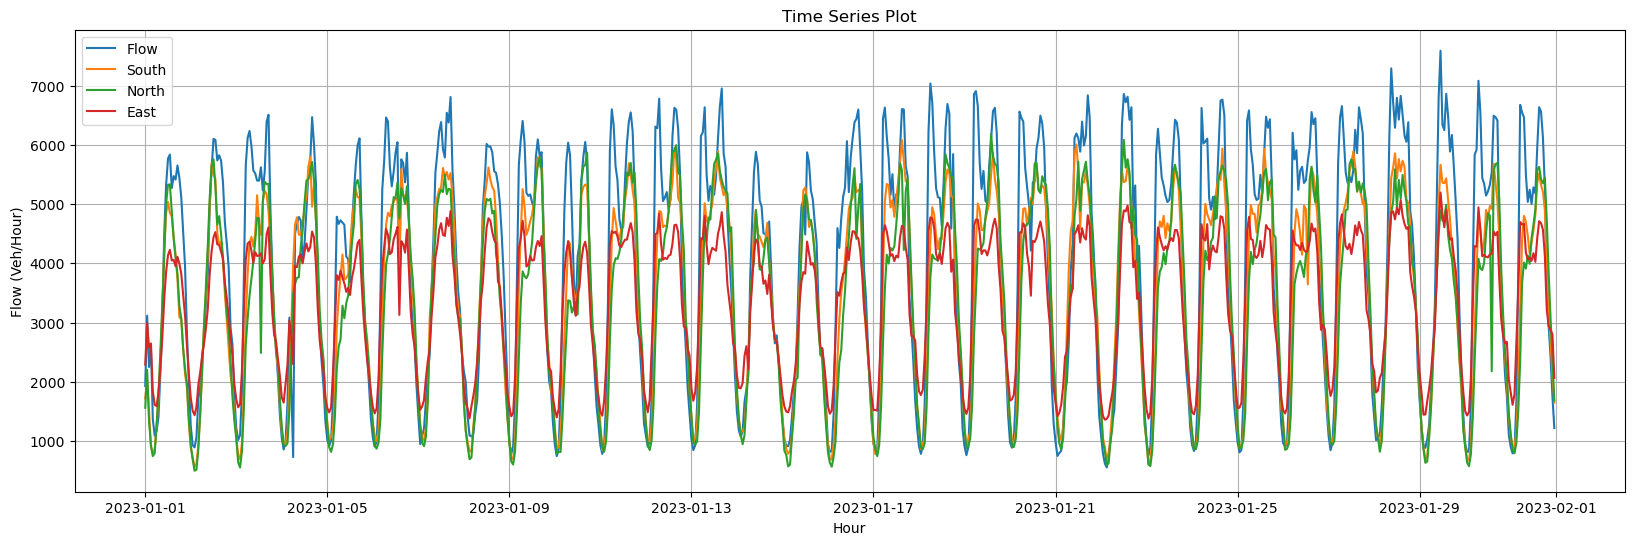

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(data['Flow (Veh/Hour)'],label = 'Flow')
plt.plot(data['South'],label = 'South')
plt.plot(data['North'],label = 'North')
plt.plot(data['East'],label = 'East')
plt.xlabel('Hour')
plt.ylabel('Flow (Veh/Hour)')
plt.title('Time Series Plot')
plt.grid(True)
plt.legend()
plt.show()

Normalize the data before doing other data processing:

In [5]:
from sklearn.preprocessing import StandardScaler

X = data.drop('Flow (Veh/Hour)', axis=1)
y = data['Flow (Veh/Hour)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled


array([[-0.80160672, -0.05633421, -1.04575045, ..., -0.9864394 ,
        -1.11276421,  1.474686  ],
       [-0.53174455, -0.26706401, -0.45004738, ..., -0.34748369,
        -0.71971362,  1.474686  ],
       [-0.8315914 ,  0.63606371, -0.88515699, ..., -0.72081638,
        -1.2515239 ,  1.474686  ],
       ...,
       [-0.66667563,  0.69627222, -0.79532634, ..., -0.45154219,
        -0.17995675, -0.93138063],
       [-0.78661437,  0.38770359, -1.13352297, ..., -0.51635056,
        -0.60968391, -0.93138063],
       [-0.95153014,  0.7640068 , -1.40253064, ..., -1.19181802,
        -1.03818851, -0.93138063]])

Computing correlations between feature variables

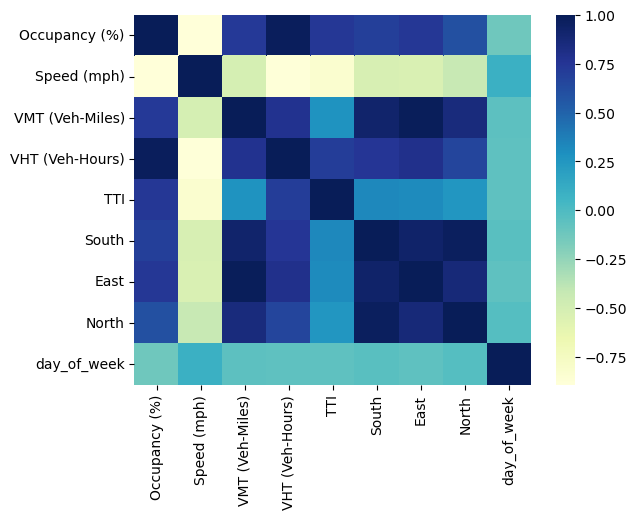

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation coefficient
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
correlation_matrix = X_scaled_df.corr()

sns.heatmap(correlation_matrix, cmap="YlGnBu")
plt.show()

Heatmap shows that Speed is significantly negatively correlated with other variables, day_of_week is not significantly correlated, and other characteristic variables are strongly correlated. Therefore, we can consider principal component analysis (PCA) for feature reduction.


Since the PCA method needs to specify the target dimension after dimension reduction, it is not known how many dimensional feature vectors need to be retained. Therefore, it is necessary to calculate the explained variance and calculate the cumulative value in order to obtain the most suitable feature vector with several dimensions.

In [8]:
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# View the proportion of variance explained
explained_variance_ratio = pca.explained_variance_ratio_
print('Explained Variance Ratio:', explained_variance_ratio)

Explained Variance Ratio: [0.66163295 0.17277416 0.10995156 0.02991464 0.01455227 0.00726757
 0.0016746  0.00133825 0.000894  ]


In [9]:
cumulative_variance = np.cumsum(explained_variance_ratio)
cumulative_variance

n_components = np.where(cumulative_variance >= 0.99)[0][0] + 1
print(f'Number of components to explain 99% variance: {n_components}')


Number of components to explain 99% variance: 6


The above results show that the six characteristic variables can explain 99% of the target variable. So we can set the target dimension of PCA to 6

In [10]:
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)
X_pca_reduced

array([[-2.21709894,  0.78661664,  1.48839355, -0.10765951, -0.20528344,
         0.39210968],
       [-1.2290815 ,  0.45300296,  1.47709033, -0.36050036, -0.11621337,
         0.49759154],
       [-2.47593488,  0.24791677,  1.40386822, -0.4535967 ,  0.20259642,
         0.13478894],
       ...,
       [-1.55976744, -0.17277438, -1.00224557,  0.35093852, -0.04425107,
        -0.10818662],
       [-1.94247351,  0.39009171, -0.95878419,  0.25227985, -0.07335024,
         0.17727257],
       [-2.84226142,  0.57477883, -0.97028659,  0.19129613, -0.0703979 ,
        -0.10164518]])

## LSTM Model Building

The data processing steps are completed, and the modeling can begin below.
First you need to standardize the data

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24

# Standardize the target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Create serialized data
X_seq, y_seq = create_dataset(X_pca_reduced, y_scaled, time_steps)

# Divide training set and test set
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [12]:
# Create a neural network model structure function：
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

import tensorflow.keras.backend as K


def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=16),
                   activation='relu',
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=16),
                   activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'), clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')

    return model


C:\Users\Xinyi Liu\AppData\Local\Temp\ipykernel_26616\198793105.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization


Create a tuner object using the BayesianOptimization method. 
max_trials=50 means that the tuner will search for 50 different hyperparameter combinations, executions_per_trial means that each model is trained three times to eliminate random errors; the final file is stored in the "output/lstm_tuning" folder, and then the model can be read directly without having to search again hyperparameters。

In [13]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50, 
    executions_per_trial=3,  
    directory='output',
    project_name='lstm_tuning')

INFO:tensorflow:Reloading Tuner from output\lstm_tuning\tuner0.json


Method1: running the cell below to tuning Hyperparameters and build the best_model. But it may take a very long time

In [12]:

tuner.search(X_train, y_train, epochs=20, validation_split=0.2)


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 50 Complete [00h 00m 59s]
val_loss: 0.04266491656502088

Best val_loss So Far: 0.03724837675690651
Total elapsed time: 00h 50m 26s
INFO:tensorflow:Oracle triggered exit


Method2: Runnning the cell below to read the best hyperparameters that have been searched from the output folder

In [63]:
from kerastuner import BayesianOptimization

def reload_tuner():
    return BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=50,
        executions_per_trial=3,
        directory='output',
        project_name='lstm_tuning',
        overwrite=False)

loaded_tuner = reload_tuner()


best_model = loaded_tuner.get_best_models(num_models=1)[0]

best_hyperparameters = loaded_tuner.get_best_hyperparameters(num_trials=1)[0]


INFO:tensorflow:Reloading Tuner from output\lstm_tuning\tuner0.json


In [64]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


See what the best hyperparameters are selected, and what the structure of the LSTM model looks like.

In [65]:
best_hyperparameters_dict = best_hyperparameters.get_config()

print("Best Model Hyperparameters:")
for name, value in best_hyperparameters_dict.items():
    print(f"{name}: {value}")

Best Model Hyperparameters:
space: [{'class_name': 'Int', 'config': {'name': 'units_1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout_1', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'units_2', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout_2', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'learning_rate', 'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}}]
values: {'units_1': 112, 'dropout_1': 0.1, 'units_2': 32, 'dropout_2': 0.1, 'learning_rate': 0.01}


In [110]:
from keras_sequential_ascii import keras2ascii

keras2ascii(best_model)


           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     24    6
                LSTM   LLLLL -------------------     53312    74.1%
                relu   #####     24  112
             Dropout    | || -------------------         0     0.0%
                       #####     24  112
                LSTM   LLLLL -------------------     18560    25.8%
                relu   #####          32
             Dropout    | || -------------------         0     0.0%
                       #####          32
               Dense   XXXXX -------------------        33     0.0%
                       #####           1


Fit the model to the training data. Early_stopping is added to this model to prevent the gradient of the model from disappearing or exploding.

In [139]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size=72,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=False
)

Epoch 1/50
7/7 [==============================] - 2s 70ms/step - loss: 1.8560 - val_loss: 1.0436
Epoch 2/50
7/7 [==============================] - 0s 30ms/step - loss: 0.5322 - val_loss: 0.2419
Epoch 3/50
7/7 [==============================] - 0s 30ms/step - loss: 0.2176 - val_loss: 0.1401
Epoch 4/50
7/7 [==============================] - 0s 31ms/step - loss: 0.1291 - val_loss: 0.1046
Epoch 5/50
7/7 [==============================] - 0s 35ms/step - loss: 0.1139 - val_loss: 0.1024
Epoch 6/50
7/7 [==============================] - 0s 35ms/step - loss: 0.1025 - val_loss: 0.0709
Epoch 7/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0832 - val_loss: 0.0706
Epoch 8/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0806 - val_loss: 0.0645
Epoch 9/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0812 - val_loss: 0.0522
Epoch 10/50
7/7 [==============================] - 0s 48ms/step - loss: 0.0650 - val_loss: 0.0544
Epoch 11/50
7/7 [============

Plot the loss function curve

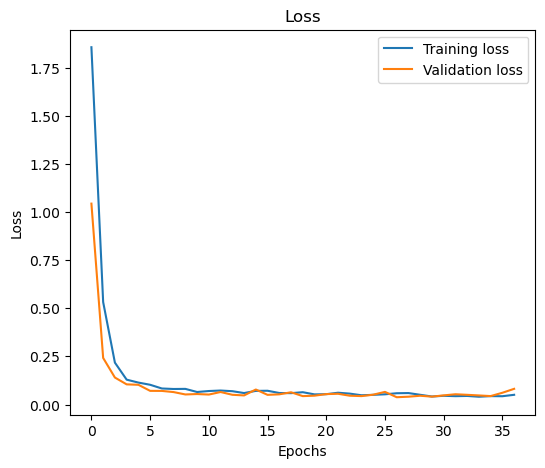

In [140]:
import matplotlib.pyplot as plt

# Graphing Loss
def plot_loss(history):
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plotting a Loss chart
    ax.plot(history.history['loss'], label='Training loss')
    ax.plot(history.history['val_loss'], label='Validation loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.show()

# Calling plotting function
plot_loss(history)


Validate the predicted value with test data and compare it to the true value:

5/5 [==============================] - 0s 8ms/step


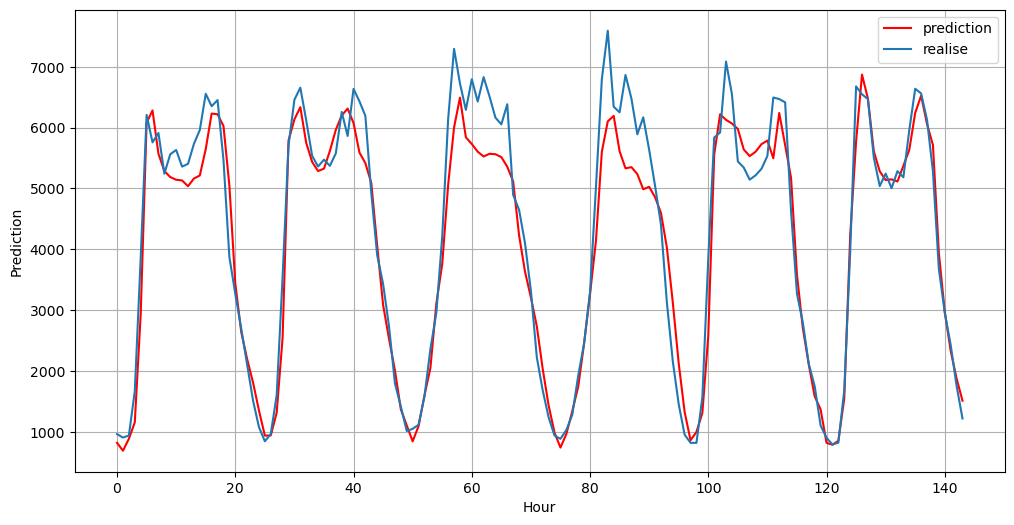

In [146]:

y_pred = best_model.predict(X_test)

# 逆标准化预测结果
y_pred_inverse = y_scaler.inverse_transform(y_pred)
y_test_inverse = y_scaler.inverse_transform(y_test)

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(y_pred_inverse, label = 'prediction', color = 'red')
plt.plot(y_test_inverse, label = 'realise')

plt.xlabel('Hour')
plt.ylabel('Prediction')
plt.grid(True)
plt.legend()
plt.show()


Calculate statistical indicators related to the evaluation model

In [157]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
normalized_y_test = scaler.fit_transform(y_test)
normalized_y_pred = scaler.fit_transform(y_pred)

mse = mean_squared_error(normalized_y_test, normalized_y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(normalized_y_test, normalized_y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 0.00694224662492872
RMSE: 0.08332014537270516
MAE: 0.06628688205370799
